# Gaussian Process with Mass Transfer Sequences

In [183]:
# Path to the directory that has all the resampled files you wish to use
resamp_path = '/data/disk2/fragkos/BinaryGrid/resampled/fine_grid/100_step/'
Mike_path = '/home/evol/zevin/test_MT/100_step/'

# Choose which resamplings to use
# For reference: 'all' = ['star_1_mass' , 'star_2_mass', 'log_Teff', 'log_L', 'log_R', 'period_days', 'lg_mstar_dot_1', 'age']
resamp = ['all-2.0', 'age-star_1_mass-2.0']

s=100

### Initialize & Read in data

#### Import packages

In [184]:
from pylab import *
import numpy as np
import scipy as sp
import pandas as pd
from scipy.interpolate import griddata
import time
import os
import multiprocessing

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import sys
# sys.path.append('/Users/michaelzevin/Documents/Machine Learning/scikit-learn/') # points to dev version of sklearn on local

import sklearn
from sklearn import gaussian_process
GP = gaussian_process.GaussianProcess
GPR = gaussian_process.GaussianProcessRegressor
GPC = gaussian_process.GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern as matern, \
        ExpSineSquared as ess
from sklearn import cross_validation

print "Scikit-learn version: %s" % (sklearn.__version__)


Scikit-learn version: 0.18.dev0


#### Read in the inputs & outputs for each track

In [185]:
# First, read inputs for a single track (they will be consistent for all resamplings)

# Define the path to the first resapling's directory
dir_path = resamp_path + resamp[0] + '/'
inputs = []

for file in os.listdir(dir_path):
    x = np.load(dir_path + file)
    
    # Read in all inputs
    inputs.append((np.float(x['Mbh_init']),np.float(x['M2_init']),np.float(x['P_init']),np.float(x['Z_init'])))

#2MIKE TRACK
x = np.load(Mike_path+'age-star_1_mass-2.0/15_10_2.npz')
inputs.append((np.float(x['Mbh_init']),np.float(x['M2_init']),np.float(x['P_init']),0.02))

# Reshape as array            
inputs = np.reshape(inputs,[len(inputs),4]) # 4 inputs

# Store as a dataframe
inputs = pd.DataFrame({"Mbh_init": inputs[:,0], "M2_init": inputs[:,1], "P_init": inputs[:,2], \
                       "Z_init": inputs[:,3]})


print 'This grid contains:'
print 'Mbh_init: %f - %f' % (inputs["Mbh_init"].min(), inputs["Mbh_init"].max())
print 'M2_init: %f - %f' % (inputs["M2_init"].min(), inputs["M2_init"].max())
print 'P_init: %f - %f' % (inputs["P_init"].min(), inputs["P_init"].max())
print 'Z_init: %f - %f' % (inputs["Z_init"].min(), inputs["Z_init"].max())


This grid contains:
Mbh_init: 4.003083 - 15.997272
M2_init: 3.008124 - 17.996001
P_init: 0.649461 - 6.310645
Z_init: 0.000101 - 0.029708


In [186]:
# Normalize the inputs

inputs_norm = pd.DataFrame({"Mbh_init": inputs['Mbh_init']/inputs['Mbh_init'].max(), \
                            "M2_init": inputs['M2_init']/inputs['M2_init'].max(), \
                            "P_init": inputs['P_init']/inputs['P_init'].max(), \
                            "Z_init": inputs['Z_init']/inputs['Z_init'].max()})

### Plot parameter space coverage

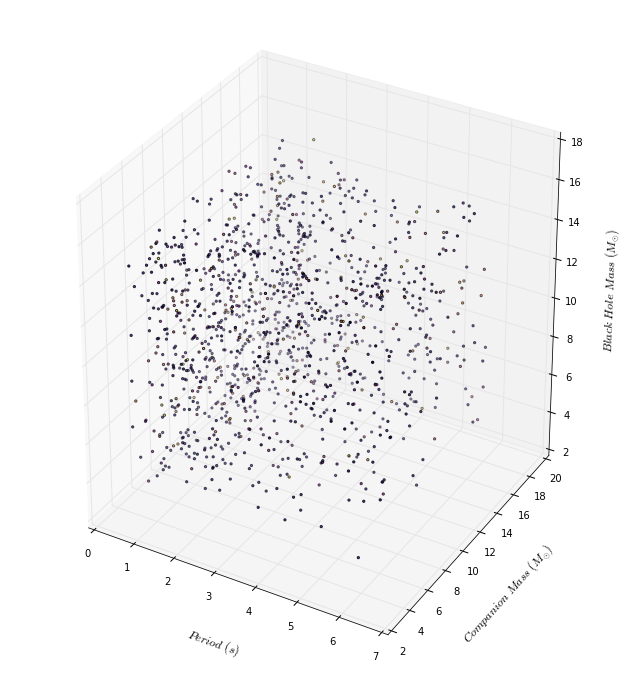

In [187]:
fig=plt.figure(figsize = (11,12), facecolor = 'white')
ax = fig.add_subplot(111, projection='3d')

ax.set_zlabel('$Black\ Hole\ Mass\ (M_{\odot})$', rotation=0, labelpad=20, size=12)
ax.set_ylabel('$Companion\ Mass\ (M_{\odot})$', rotation=0, labelpad=20, size=12)
ax.set_xlabel('$Period\ (s)$', rotation=0, labelpad=20, size=12)

z_range = inputs['Z_init'].max()-inputs['Z_init'].min()
pts = ax.scatter(inputs['P_init'], inputs['M2_init'], inputs['Mbh_init'], zdir='z', s=5, cmap='plasma',\
           c = (1.0/z_range)*inputs['Z_init'])


In [188]:
# Next, read the outputs for the different resamplings specified above

resamplings={} # dict of dataframes with different resampling

for path in resamp:
    dir_path = resamp_path + path + '/'
    outputs=[]
    
    for file in os.listdir(dir_path):
        x = np.load(dir_path + file)
        outputs.append(x['x_resamp'])
    
    # Load 2MIKE track
    x = np.load(Mike_path+path+'/15_10_2.npz')
    outputs.append(x['x_resamp'])
    
    outputs = np.asarray(outputs)
                
    resamplings[path] = outputs # store different resampling matricies
    # matrix structure: [track][timestep][outputs]


### Pick the parameters to interpolate

#### Choose the paramerers for interpolation

In [189]:
interp_params = ['star_1_mass', 'log_Teff', 'period_days', 'lg_mstar_dot_1', 'age_since_RLO']


In [190]:
param_names=['log_dt','log_abs_mdot','he_core_mass','c_core_mass','o_core_mass','mass_conv_core','log_LH','log_LHe','log_LZ',
    'log_Lnuc','log_Teff','log_L','log_R','log_g','surf_avg_omega','surf_avg_omega_div_omega_crit','center_h1','center_he4',
    'center_c12','center_o16','surface_c12','surface_o16','total_mass_h1','total_mass_he4','log_center_P','log_center_Rho',
    'log_center_T','model_number','age','period_days','binary_separation','v_orb_1','v_orb_2','star_1_radius','rl_1',
    'rl_2','rl_relative_overflow_1','rl_relative_overflow_2','star_1_mass','star_2_mass','lg_mtransfer_rate','lg_mstar_dot_1',
    'lg_mstar_dot_2','lg_system_mdot_1','lg_system_mdot_2','lg_wind_mdot_1','lg_wind_mdot_2','xfer_fraction','J_orb','Jdot',
    'jdot_mb','jdot_gr','jdot_ml','jdot_ls','jdot_missing_wind','extra_jdot','donor_index','point_mass_index','r_tau100',
    'r_tau1000','t_dynamical_tau100','t_dynamical_tau1000','m_dynamical_tau100','m_dynamical_tau100_1','t_thermal_tau1000',
    't_thermal_tau1000_1','m_thermal_tau100','m_thermal_tau1000','age_since_RLO','frac_age_RLO','derived_age']

### NOTE: star_1 = 2 (i.e. star_1_mass = M2), star_2 = Mbh (eg. star_2_mass = Mbh) ###


numbers = np.arange(0, len(param_names)+1, 1)

# Create dictionary 'parameters' relating parameter names to their correct number
parameters = {}
for p in xrange(len(param_names)):
    parameters[param_names[p]] = numbers[p]
        
param_numbers = [parameters[x] for x in interp_params]

#### Add new age parameters: 'age since RLO' and 'fractional age of RLO phase'

$$agesinceRLO_{i} = age_{i} - age_{initial}$$

$$fracageRLO = \frac{age_{i}}{age_{final}-age_{initial}}$$

$$derivedage_{i} = \frac{dM_{bh}}{M_{bh,\odot}} = \frac{M2_{i}-M2_{i-1}}{10^{log(\dot{M2_{i}})}}$$

In [191]:
temp = np.zeros((len(outputs), s, 3))

for matrix in resamplings:
    # First, append zeros to the matrix of outputs for the synthesized parameters
    resamplings[matrix] = np.dstack((resamplings[matrix], temp))
    
    # Find the total change in age for each track
    ages_initial = resamplings[matrix][:,0,parameters['age']]
    ages_final = resamplings[matrix][:,s-1,parameters['age']]
    delta_ages = ages_final - ages_initial

    # Save initial ages into matrix 'q' over all timesteps
    q = np.ones((len(outputs),s))
    for i in xrange(len(q.T)):
        q[:,i] = q[:,i]*ages_initial
    
    # Create new parameter 'age since RLO'
    resamplings[matrix][:,:,68] = resamplings[matrix][:,:,parameters['age']]-q
    
    
    # Save delta ages into matrix 'w' over all timesteps
    w = np.ones((len(outputs),s))
    for i in xrange(len(w.T)):
        w[:,i] = w[:,i]*delta_ages
    
    # Create new parameter 'fractional age of RLO phase'
    resamplings[matrix][:,:,69] = resamplings[matrix][:,:,parameters['age']]-q
    resamplings[matrix][:,:,69] = resamplings[matrix][:,:,69]/w
    
    
    # Create new parameter 'age since RLO' using m_dot and star mass
    for track in xrange(len(resamplings[matrix])):
        for i in range(1, s):   # the first step value will be 0 by definition
            resamplings[matrix][track,i,70] = resamplings[matrix][track,(i-1),70] \
                                            + np.abs(resamplings[matrix][track,i,parameters['star_1_mass']] \
                                            - resamplings[matrix][track,(i-1),parameters['star_1_mass']]) \
                                            / (10**resamplings[matrix][track,i,parameters['lg_mstar_dot_1']])

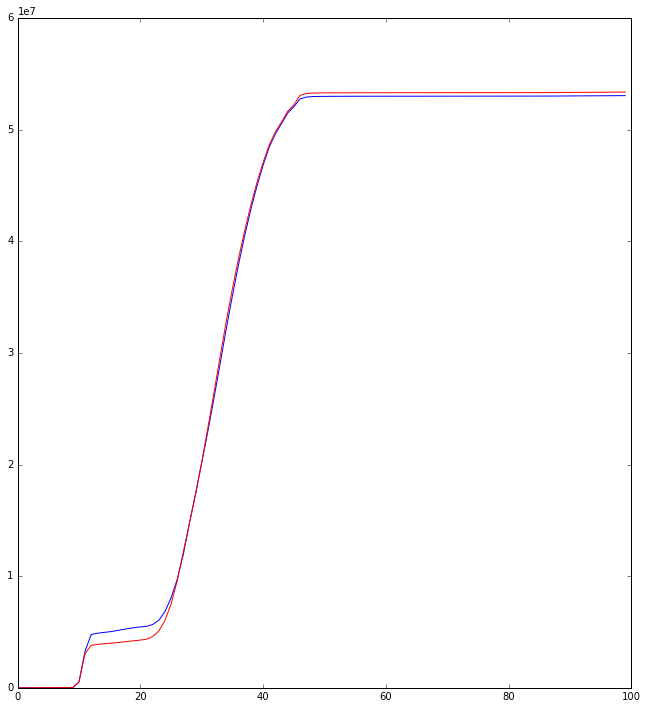

In [192]:
# Check to see if derived_age matches with age_since_RLO

fig=plt.figure(figsize = (11,12), facecolor = 'white')
track = 500
plt.plot(resamplings['all-2.0'][track,:,parameters['age_since_RLO']], color='b')
plt.plot(resamplings['all-2.0'][track,:,parameters['derived_age']], color='r')

In [193]:
inputs.iloc[-1]

M2_init     14.99910
Mbh_init    10.00000
P_init       2.00014
Z_init       0.02000
Name: 1273, dtype: float64

In [196]:
# Plot tracks close to 2MIKE
nearby_tracks=[]
nearby_tracks_props=[]

for i in range(len(inputs)-1): # The testing track is the last in this array, so don't add this
    if (8 < inputs.iloc[i]['Mbh_init'] < 12) & (13 < inputs.iloc[i]['M2_init'] < 17)\
    & (1 < inputs.iloc[i]['P_init'] < 3) & (0.01 < inputs.iloc[i]['Z_init'] < 0.03):
        nearby_tracks += [i]
        nearby_tracks_props.append(inputs.iloc[i])
        print i
        print inputs.iloc[i]

10
M2_init     13.659572
Mbh_init    11.062779
P_init       1.143332
Z_init       0.014693
Name: 10, dtype: float64
24
M2_init     13.383547
Mbh_init    11.308005
P_init       2.475060
Z_init       0.029708
Name: 24, dtype: float64
413
M2_init     13.361479
Mbh_init    11.944300
P_init       1.161946
Z_init       0.012310
Name: 413, dtype: float64
593
M2_init     13.551670
Mbh_init    10.578251
P_init       2.391105
Z_init       0.012420
Name: 593, dtype: float64
598
M2_init     13.508608
Mbh_init     8.781632
P_init       1.488448
Z_init       0.023846
Name: 598, dtype: float64
827
M2_init     16.767779
Mbh_init    10.127238
P_init       1.832333
Z_init       0.017071
Name: 827, dtype: float64
858
M2_init     16.827961
Mbh_init    10.494911
P_init       1.677549
Z_init       0.028610
Name: 858, dtype: float64
888
M2_init     15.817258
Mbh_init     8.391362
P_init       1.206461
Z_init       0.010025
Name: 888, dtype: float64
941
M2_init     15.659942
Mbh_init     8.379703
P_init      

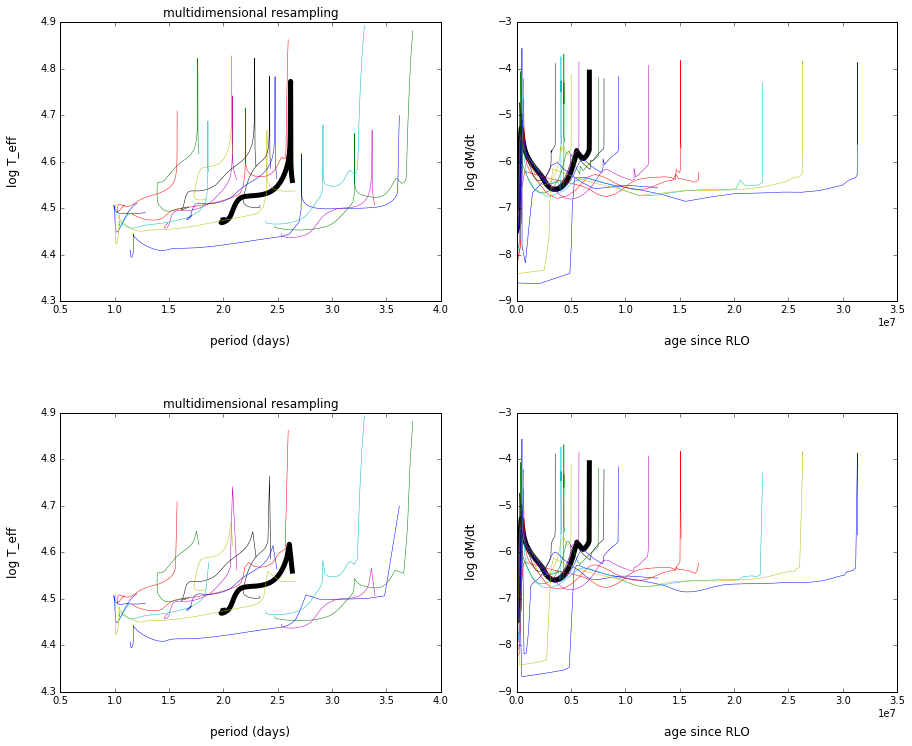

In [197]:
# First, print comparisons for 'all' resampling

steps = np.arange(s)
fig=plt.figure(figsize = (15,12))
fig.subplots_adjust(wspace=.2,hspace=.4)


# Multidimensional Resampling

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('period (days)', rotation=0, labelpad=20, size=12)
ax1.set_ylabel('log T_eff', rotation=90, labelpad=20, size=12)
plt.title('multidimensional resampling')
# Plot test track
ax1.plot(resamplings[resamp[0]][len(inputs)-1,steps,parameters['period_days']], \
                                resamplings[resamp[0]][len(inputs)-1,steps,parameters['log_Teff']], 'k', linewidth=5)
# Plot nearby tracks
for t in nearby_tracks:
    ax1.plot(resamplings[resamp[0]][t,steps,parameters['period_days']], \
                                resamplings[resamp[0]][t,steps,parameters['log_Teff']], linewidth=0.5)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('age since RLO', rotation=0, labelpad=20, size=12)
ax2.set_ylabel('log dM/dt', rotation=90, labelpad=20, size=12)
# Plot test track
ax2.plot(resamplings[resamp[0]][len(inputs)-1,steps,parameters['age_since_RLO']], \
                                resamplings[resamp[0]][len(inputs)-1,steps,parameters['lg_mstar_dot_1']], 'k', linewidth=5)
# Plot nearby tracks
for t in nearby_tracks:
    ax2.plot(resamplings[resamp[0]][t,steps,parameters['age_since_RLO']], \
                                resamplings[resamp[0]][t,steps,parameters['lg_mstar_dot_1']], linewidth=0.5)

 
# Mass Resampling


ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('period (days)', rotation=0, labelpad=20, size=12)
ax3.set_ylabel('log T_eff', rotation=90, labelpad=20, size=12)
plt.title('multidimensional resampling')
# Plot test track
ax3.plot(resamplings[resamp[1]][len(inputs)-1,steps,parameters['period_days']], \
                                resamplings[resamp[1]][len(inputs)-1,steps,parameters['log_Teff']], 'k', linewidth=5)
# Plot nearby tracks
for t in nearby_tracks:
    ax3.plot(resamplings[resamp[1]][t,steps,parameters['period_days']], \
                                resamplings[resamp[1]][t,steps,parameters['log_Teff']], linewidth=0.5)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('age since RLO', rotation=0, labelpad=20, size=12)
ax4.set_ylabel('log dM/dt', rotation=90, labelpad=20, size=12)
# Plot test track
ax4.plot(resamplings[resamp[1]][len(inputs)-1,steps,parameters['age_since_RLO']], \
                                resamplings[resamp[1]][len(inputs)-1,steps,parameters['lg_mstar_dot_1']], 'k', linewidth=5)
# Plot nearby tracks
for t in nearby_tracks:
    ax4.plot(resamplings[resamp[1]][t,steps,parameters['age_since_RLO']], \
                                resamplings[resamp[1]][t,steps,parameters['lg_mstar_dot_1']], linewidth=0.5)


### Split dataset into training, validation, and testing sets

In [198]:
# Need to use ShuffleSplit to maintain same training/testing indices
test_size = 0.0
indices = cross_validation.ShuffleSplit(len(inputs), n_iter=1, test_size=test_size)

# Save training and testing indices
for train, test in indices:
    train_index = train
    test_index = test


In [199]:
# For 2MIKE sample...
train_index = nearby_tracks[:]
#train_index = np.arange(len(inputs)-1)
test_index = len(inputs)-1

### Define GP and auxillary functions

In [200]:
# Notation for parallelizing: data[0]: X_train, data[1]: y_train, data[2]: X_test



'''Do some fancy kernel stuff'''

def GPR_scikit(data):
    
    X = np.atleast_2d(data[0])
    y = np.atleast_2d(data[1]).T # Need to transpose to make dimensions match
    
    kernel = C() * RBF()
    yerr = 1e-7
    #gp = GPR(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)
    gp = GP(corr='squared_exponential', theta0=1e-1, thetaL=1e-4, thetaU=1e0, nugget = yerr)
    
    gp.fit(X, y)
    
    X_pred = np.atleast_2d(data[2])
    
    # GPR
    #y_pred, sigma = gp.predict(X_pred, return_std=True)
    #y_pred = np.reshape(y_pred,len(y_pred))
    
    # GP
    y_pred, sigma2_pred = gp.predict(X_pred, eval_MSE=True)
    sigma = sqrt(sigma2_pred)
    
    return y_pred, sigma



def linear_interp(data):
    value = sp.interpolate.griddata(data[0],data[1],data[2],method='linear', fill_value=0.0)
    return value

#### Set up multiprocessing

In [201]:
# Specify number of cores to run on
num_cores = multiprocessing.cpu_count()
pool = multiprocessing.Pool(num_cores-2)


### Run GP interpolation over different folds, over all outputs params, over all timesteps

In [202]:
interp = {} # These dicts will store the predictions and sigmas associated with each resampling
error = {}

results=[]
for resamp in resamplings:
    print "Current resampling: %s" % (resamp)
    interp[resamp]={}
    error[resamp]={}
    X_train, X_test = inputs_norm.iloc[train_index], inputs_norm.iloc[test_index] # Locate based on index in dataframe
    y_train = resamplings[resamp][train_index] # , y_test..., resamplings[resamp][test_index]
    
    # Run GP over 1 output parameter at a time
    for num in param_numbers:
        
        print "   Current parameter: %s" % (param_names[num])
        # GP inteprolation
        start_time = time.time()   # Start the clock
        
        # First, create an array of tuples containing X_train (0), y_train (1), & X_test (2) over all timesteps
        temp=[]
 
        for timestep in arange(s):
            combined = (X_train, y_train[:,timestep,num], X_test)
            temp.append(combined) # Now, temp is holding the information needed 
        
        # Parallelize over timesteps
        results = pool.map(GPR_scikit,temp)    # CHANGE THIS LINE TO USE DIFFERENT GP REGRESSOR
        
        # Add results to matrix holding output predictions & error
        results = np.asarray(results)
        interp[resamp][param_names[num]] = results[:,0,:].T
        error[resamp][param_names[num]] = results[:,1,:].T
        
        # See how long it took
        elapsed = time.time() - start_time   # See how long it took 
        print '      Done with GP interpolation for %s...it only took %f seconds!' % (param_names[num],elapsed)



Current resampling: age-star_1_mass-2.0
   Current parameter: star_1_mass
      Done with GP interpolation for star_1_mass...it only took 0.269523 seconds!
   Current parameter: log_Teff
      Done with GP interpolation for log_Teff...it only took 0.103787 seconds!
   Current parameter: period_days
      Done with GP interpolation for period_days...it only took 0.110184 seconds!
   Current parameter: lg_mstar_dot_1
      Done with GP interpolation for lg_mstar_dot_1...it only took 0.107021 seconds!
   Current parameter: age_since_RLO
      Done with GP interpolation for age_since_RLO...it only took 0.099194 seconds!
Current resampling: all-2.0
   Current parameter: star_1_mass
      Done with GP interpolation for star_1_mass...it only took 0.091377 seconds!
   Current parameter: log_Teff
      Done with GP interpolation for log_Teff...it only took 0.100761 seconds!
   Current parameter: period_days
      Done with GP interpolation for period_days...it only took 0.088883 seconds!
   Cur

In [203]:
# Linear interpolation, and store actual outputs
linear = {} # These dicts will store the predictions and sigmas associated with each resampling
actual = {}

results=[]
for resamp in resamplings:
    print "Current resampling: %s" % (resamp)
    linear[resamp]={}
    actual[resamp]={}
    X_train, X_test = inputs_norm.iloc[train_index], inputs_norm.iloc[test_index] # Locate based on index in dataframe
    y_train = resamplings[resamp][train_index] # , y_test, resamplings[resamp][test_index]

    
    # Run GP over 1 output parameter at a time
    for num in param_numbers:
        
        print "   Current parameter: %s" % (param_names[num])
        # GP inteprolation
        start_time = time.time()   # Start the clock
        
        # First, create an array of tuples containing X_train (0), y_train (1), & X_test (2) over all timesteps
        temp=[]
        
        for timestep in arange(s):
            combined = (X_train, y_train[:,timestep,num], X_test)
            temp.append(combined) # Now, temp is holding the information needed 
        
        # Parallelize over timesteps
        results = pool.map(linear_interp,temp)
        
        # Add results to matrix holding output predictions & error
        results = np.asarray(results)
        linear[resamp][param_names[num]] = results.T
        #actual[resamp][param_names[num]] = y_test[:,:,num]
        
        # See how long it took
        elapsed = time.time() - start_time   # See how long it took 
        print '      Done with linear interpolation for %s...it only took %f seconds!' % (param_names[num],elapsed)


Current resampling: age-star_1_mass-2.0
   Current parameter: star_1_mass
      Done with linear interpolation for star_1_mass...it only took 0.111222 seconds!
   Current parameter: log_Teff
      Done with linear interpolation for log_Teff...it only took 0.095205 seconds!
   Current parameter: period_days
      Done with linear interpolation for period_days...it only took 0.094249 seconds!
   Current parameter: lg_mstar_dot_1
      Done with linear interpolation for lg_mstar_dot_1...it only took 0.091957 seconds!
   Current parameter: age_since_RLO
      Done with linear interpolation for age_since_RLO...it only took 0.095417 seconds!
Current resampling: all-2.0
   Current parameter: star_1_mass
      Done with linear interpolation for star_1_mass...it only took 0.092825 seconds!
   Current parameter: log_Teff
      Done with linear interpolation for log_Teff...it only took 0.095779 seconds!
   Current parameter: period_days
      Done with linear interpolation for period_days...it on

In [204]:
# Save as pickle
import pickle

# Change this accordingly
pkl_path = 'test'+'-2MIKE'
#pkl_path = 'all_star1mass_resamp'+'-test_' + str(test_size)

data = {"input": np.asarray(X_test), "interp": interp, "error": error, \
        "linear": linear}#, "actual": actual}

pickle.dump(data, open("/home/evol/zevin/pickles/"+pkl_path, "wb"))

# START HERE AFTER IF LOADING PICKLE

In [205]:
# Make sure to run initialization cell first...

import pickle

pkl_path = "test-2MIKE"
data = pickle.load(open("/home/evol/zevin/pickles/"+pkl_path, "rb"))

### Plot actual evolutionary tracks compared to interpolations

In [207]:
# Read linear

resamp = ['all-2.0', 'age-star_1_mass-2.0']

lin_all={}
T_lin_all = data['linear'][resamp[0]]['log_Teff']
lin_all['T'] = np.reshape(T_lin_all, s)
P_lin_all = data['linear'][resamp[0]]['period_days']
lin_all['P'] = np.reshape(P_lin_all, s)
dmdt_lin_all = data['linear'][resamp[0]]['lg_mstar_dot_1']
lin_all['dmdt'] = np.reshape(dmdt_lin_all, s)
asr_lin_all = data['linear'][resamp[0]]['age_since_RLO']
lin_all['asr'] = np.reshape(asr_lin_all, s)
m1_lin_all = data['linear'][resamp[0]]['star_1_mass']
lin_all['m1'] = np.reshape(m1_lin_all, s)

lin_mass={}
T_lin_mass = data['linear'][resamp[1]]['log_Teff']
lin_mass['T'] = np.reshape(T_lin_mass, s)
P_lin_mass = data['linear'][resamp[1]]['period_days']
lin_mass['P'] = np.reshape(P_lin_mass, s)
dmdt_lin_mass = data['linear'][resamp[1]]['lg_mstar_dot_1']
lin_mass['dmdt'] = np.reshape(dmdt_lin_mass, s)
asr_lin_mass = data['linear'][resamp[1]]['age_since_RLO']
lin_mass['asr'] = np.reshape(asr_lin_all, s)
m1_lin_mass = data['linear'][resamp[1]]['star_1_mass']
lin_mass['m1'] = np.reshape(m1_lin_mass, s)




In [208]:
# Read GP interpolations & errors

gp_all={}
T_gp_all = data['interp'][resamp[0]]['log_Teff']
gp_all['T'] = np.reshape(T_gp_all, s)
P_gp_all = data['interp'][resamp[0]]['period_days']
gp_all['P'] = np.reshape(P_gp_all, s)
dmdt_gp_all = data['interp'][resamp[0]]['lg_mstar_dot_1']
gp_all['dmdt'] = np.reshape(dmdt_gp_all, s)
asr_gp_all = data['interp'][resamp[0]]['age_since_RLO']
gp_all['asr'] = np.reshape(asr_gp_all, s)
m1_gp_all = data['interp'][resamp[0]]['star_1_mass']
gp_all['m1'] = np.reshape(m1_gp_all, s)

err_all={}
T_err_all = data['error'][resamp[0]]['log_Teff']
err_all['T'] = np.reshape(T_err_all, s)
P_err_all = data['error'][resamp[0]]['period_days']
err_all['P'] = np.reshape(P_err_all, s)
dmdt_err_all = data['error'][resamp[0]]['lg_mstar_dot_1']
err_all['dmdt'] = np.reshape(dmdt_err_all, s)
asr_err_all = data['error'][resamp[0]]['age_since_RLO']
err_all['asr'] = np.reshape(asr_err_all, s)
m1_err_all = data['error'][resamp[0]]['star_1_mass']
err_all['m1'] = np.reshape(m1_err_all, s)


gp_mass={}
T_gp_mass = data['interp'][resamp[1]]['log_Teff']
gp_mass['T'] = np.reshape(T_gp_mass, s)
P_gp_mass = data['interp'][resamp[1]]['period_days']
gp_mass['P'] = np.reshape(P_gp_mass, s)
dmdt_gp_mass = data['interp'][resamp[1]]['lg_mstar_dot_1']
gp_mass['dmdt'] = np.reshape(dmdt_gp_mass, s)
asr_gp_mass = data['interp'][resamp[1]]['age_since_RLO']
gp_mass['asr'] = np.reshape(asr_gp_mass, s)
m1_gp_mass = data['interp'][resamp[1]]['star_1_mass']
gp_mass['m1'] = np.reshape(m1_gp_mass, s)

err_mass={}
T_err_mass = data['error'][resamp[1]]['log_Teff']
err_mass['T'] = np.reshape(T_err_mass, s)
P_err_mass = data['error'][resamp[1]]['period_days']
err_mass['P'] = np.reshape(P_err_mass, s)
dmdt_err_mass = data['error'][resamp[1]]['lg_mstar_dot_1']
err_mass['dmdt'] = np.reshape(dmdt_err_mass, s)
asr_err_mass = data['error'][resamp[1]]['age_since_RLO']
err_mass['asr'] = np.reshape(asr_err_mass, s)
m1_err_mass = data['error'][resamp[1]]['star_1_mass']
err_mass['m1'] = np.reshape(m1_err_mass, s)


In [216]:
# ['star_1_mass', 'log_Teff', 'period_days', 'lg_mstar_dot_1', 'age_since_RLO']
print(param_numbers)

[38, 10, 29, 41, 68]


In [210]:
# Actual values...output index all decreased by 1

act_all={}
x = np.load(Mike_path+'all-2.0/15_10_2.npz')
actual_all = x['x_resamp']
act_all['m1'] = actual_all[:,38]
act_all['T'] = actual_all[:,10]
act_all['P'] = actual_all[:,29]
act_all['dmdt'] = actual_all[:,41]
actual_age = actual_all[:,28]
act_all['asr'] = actual_age-actual_age.min()

act_mass={}
x = np.load(Mike_path+'age-lg_mstar_dot_1-2.0/15_10_2.npz')
actual_mass = x['x_resamp']
act_mass['m1'] = actual_all[:,38]
act_mass['T'] = actual_mass[:,10]
act_mass['P'] = actual_mass[:,29]
act_mass['dmdt'] = actual_mass[:,41]
actual_age = actual_mass[:,28]
act_mass['asr'] = actual_age-actual_age.min()


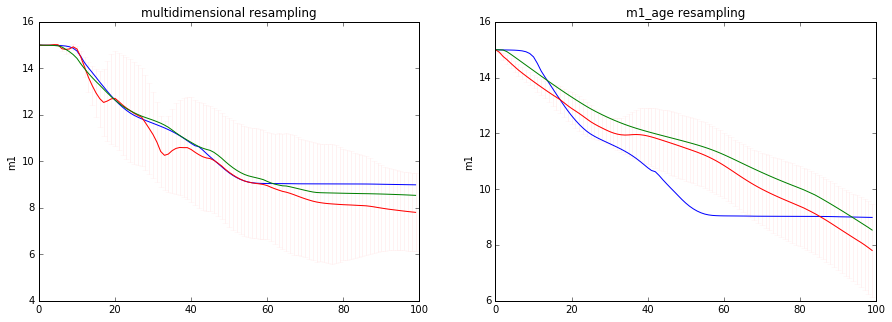

In [211]:
# 1D plots (m1)

fig=plt.figure(figsize = (15,5))

steps = np.arange(s)
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('multidimensional resampling')
ax1.set_ylabel('m1')
ax1.plot(steps, act_all['m1'], 'b')
ax1.plot(steps, gp_all['m1'], 'r')
ax1.errorbar(steps, gp_all['m1'], err_all['m1'], color='r', alpha=.05)
ax1.plot(steps, lin_all['m1'], 'g')

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('m1_age resampling')
ax2.set_ylabel('m1')
ax2.plot(steps, act_mass['m1'], 'b')
ax2.plot(steps, gp_mass['m1'], 'r')
ax2.errorbar(steps, gp_mass['m1'], err_mass['m1'], color='r', alpha=.05)
ax2.plot(steps, lin_mass['m1'], 'g')

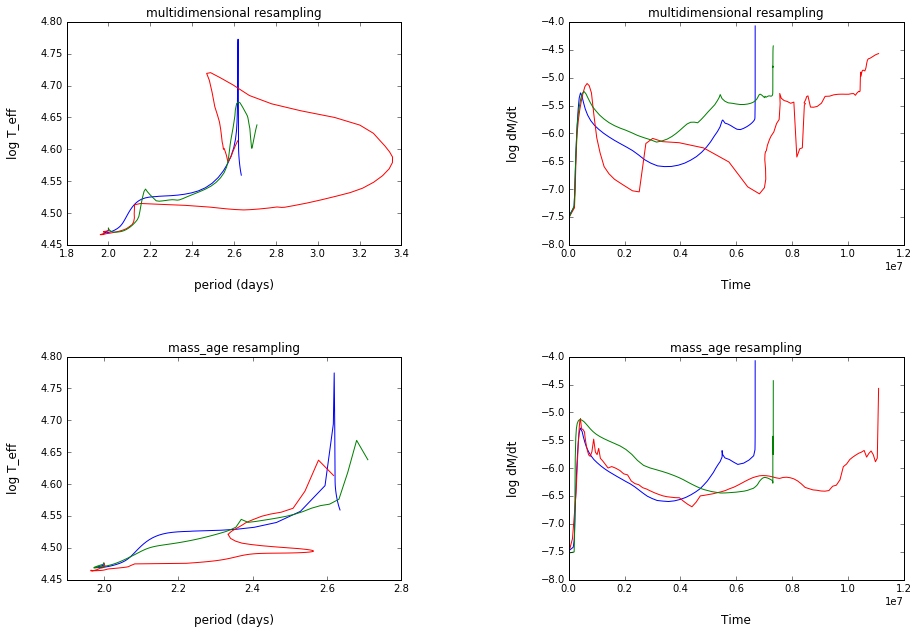

In [213]:
# 2MIKE

fig=plt.figure(figsize = (15,10))
fig.subplots_adjust(wspace=.5,hspace=.5)
ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('period (days)', rotation=0, labelpad=20, size=12)
ax1.set_ylabel('log T_eff', rotation=90, labelpad=20, size=12)

ax1.plot(act_all['P'], act_all['T'], 'b')
ax1.plot(gp_all['P'], gp_all['T'], 'r')
ax1.plot(lin_all['P'], lin_all['T'], 'g')
ax1.set_title('multidimensional resampling')

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Time', rotation=0, labelpad=20, size=12)
ax2.set_ylabel('log dM/dt', rotation=90, labelpad=20, size=12)

ax2.plot(act_all['asr'], act_all['dmdt'], 'b')
ax2.plot(gp_all['asr'], gp_all['dmdt'], 'r')
ax2.plot(lin_all['asr'], lin_all['dmdt'], 'g')
ax2.set_title('multidimensional resampling')


ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('period (days)', rotation=0, labelpad=20, size=12)
ax3.set_ylabel('log T_eff', rotation=90, labelpad=20, size=12)

ax3.plot(act_mass['P'], act_mass['T'], 'b')
ax3.plot(gp_mass['P'], gp_mass['T'], 'r')
ax3.plot(lin_mass['P'], lin_mass['T'], 'g')
ax3.set_title('mass_age resampling')

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('Time', rotation=0, labelpad=20, size=12)
ax4.set_ylabel('log dM/dt', rotation=90, labelpad=20, size=12)

ax4.plot(act_mass['asr'], act_mass['dmdt'], 'b')
ax4.plot(gp_mass['asr'], gp_mass['dmdt'], 'r')
ax4.plot(lin_mass['asr'], lin_mass['dmdt'], 'g')
ax4.set_title('mass_age resampling')


In [57]:
# First, plot all of the output parameters vs timestep

# set up plots
fig=plt.figure(figsize = (11,6*len(output_params)), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)

# set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['black'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])
lc3 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['blue'])
lc4 = LineCollection([[(0, 0)]], linestyles = ['dotted'], colors = ['green'])

# choose how many of the timesteps to plot (min 0, max 1000)
timesteps = np.arange(1000)
start = 0
stop = 1000


# Define function to make a plot for each of the output parameters
# from the Gaussian Processes & linear interp given a fold & track
def plot_evo(fold, track):
    for i in xrange(len(output_params)):
        ax = fig.add_subplot(len(output_params),1,i+1)
        ax.set_xlabel('$timestep$', rotation=0, labelpad=20, size=12)
        ax.set_ylabel(parameters[output_params[i]], rotation=90, labelpad=20, size=12)
        ax.legend([lc1, lc2, lc3, lc4], ['$actual$', '$scikit\ GP\ interpolation$', \
                                         '$scikitopt\ GP\ interpolation$', '$lin\ interpolated$'], loc=0)
        ax.set_title(parameters[output_params[i]] + " vs timestep")
        # Plot actual evolution
        ax.plot(timesteps[start:stop], outputs_act[i,track,start:stop,fold], 'k-',linewidth=2)
        # Plot GP interpolated evolution with error bars
        ax.plot(timesteps[start:stop], scikit_pred[i,track,start:stop,fold],'r--',linewidth=1)
        ax.errorbar(timesteps[start:stop], scikit_pred[i,track,start:stop,fold], 
                    yerr=scikit_sigma[i,track,start:stop,fold], linestyle='-', color='r', alpha=.1)
        # Plot optimized GP interpolated evolution with error bars
        ax.plot(timesteps[start:stop], scikitopt_pred[i,track,start:stop,fold],'b--',linewidth=1)
        ax.errorbar(timesteps[start:stop], scikitopt_pred[i,track,start:stop,fold], 
                    yerr=scikitopt_sigma[i,track,start:stop,fold], linestyle='-', color='b', alpha=.1)  
        # Plot linear interpolated evolution
        ax.plot(timesteps[start:stop], linear_pred[i,track,start:stop,fold],'g:',linewidth=2)

# Input (fold, track) to plot
fold=0
track=250
plot_evo(fold,track)
plt_path = '/home/evol/zevin/plots/'
fig.savefig(plt_path + 'interp_' + resamp)

# Check the initial condition for whatever track you plotted
def which_ICs(num):
    for train_index, test_index in folds:
        X_train, X_test = inputs[train_index], inputs[test_index]
        print X_test[num]

which_ICs(track)

NameError: name 'output_params' is not defined

### Cut out samples in which linear interpolation failed, and compare error

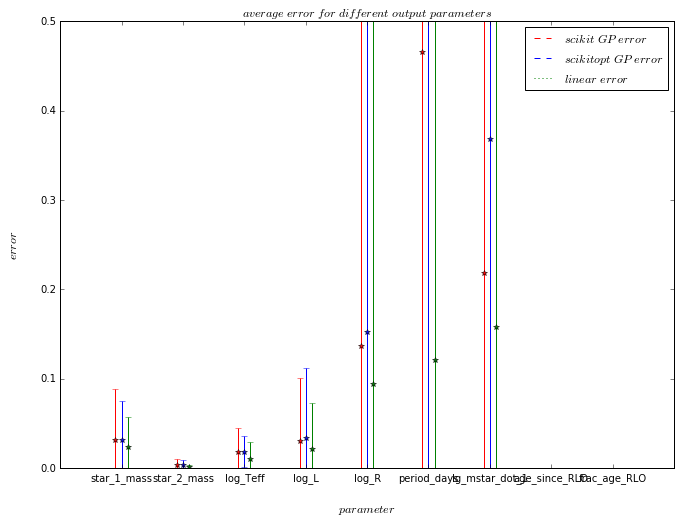

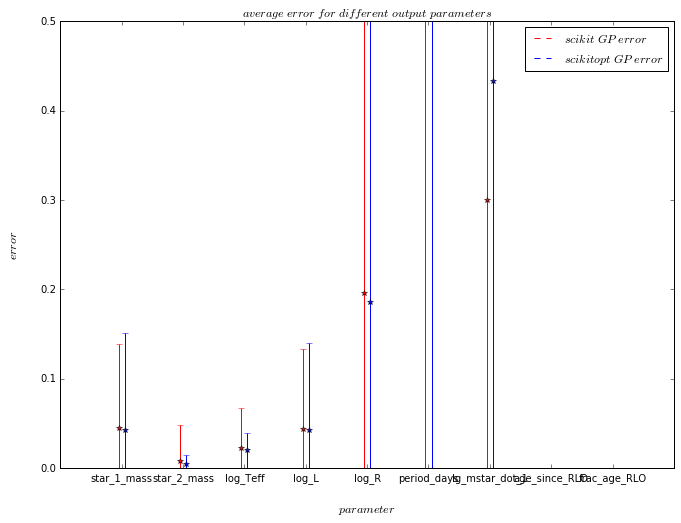

In [20]:
def avg_error(X, actual, num, fold):
    # Pop off first step value to avoid 0 divide
    #X = np.delete(X,(0),axis=2)
    #actual = np.delete(actual,(0),axis=2)
    
    q=abs((X[num,:,:,fold]-actual[num,:,:,fold])) / abs(actual[num,:,:,fold])
    avg = q.mean()
    avg_std = q.std()
    return avg, avg_std

def cut_null(linear,scikit,scikitopt,actual,output,fold):
    linear_cut=linear
    scikit_cut=scikit
    scikitopt_cut=scikitopt
    actual_cut=actual
    i=0
    while i < len(linear_cut[output,:,0,fold]):   # See if a timestep in the middle (500) is 0, since new age 
        if linear_cut[output,i,500,fold]==0.0:    # sampling starts with an age parameter of 0!!!
            linear_cut = np.delete(linear_cut,(i),axis=1)
            scikit_cut = np.delete(scikit_cut,(i),axis=1)
            scikitopt_cut = np.delete(scikitopt_cut,(i),axis=1)
            actual_cut = np.delete(actual_cut,(i),axis=1)
        else:
            i+=1
            
    return linear_cut, scikit_cut, scikitopt_cut, actual_cut

def plot_error_cut(fold,linear,scikit,scikitopt,actual):
    
    # Store averaged error and standard deviation of errors for different output parameters
    scikit_error=np.zeros(len(output_params))
    scikit_error_std=np.zeros(len(output_params))
    linear_error=np.zeros(len(output_params))
    linear_error_std=np.zeros(len(output_params))
    scikitopt_error=np.zeros(len(output_params))
    scikitopt_error_std=np.zeros(len(output_params))
        
    for num in xrange(len(output_params)):
        
        # First, cut out samples that could not be linearly interpolated
        linear_cut, scikit_cut, scikitopt_cut, actual_cut = cut_null(linear,scikit, \
                    scikitopt,actual,num,fold)
        
        # Calculate error and error std for each interpolation
        scikit_error[num], scikit_error_std[num] = avg_error(scikit_cut,actual_cut,num,fold)
        scikitopt_error[num], scikitopt_error_std[num] = avg_error(scikitopt_cut,actual_cut,num,fold)
        linear_error[num], linear_error_std[num] = avg_error(linear_cut,actual_cut,num,fold)
        
        # Plot scikit error
        ax.errorbar(x[num]-0.1, scikit_error[num], yerr=scikit_error_std[num], fmt='*', color='r', alpha=1.0)
        # Plot optimized scikit error
        ax.errorbar(x[num], scikitopt_error[num], yerr=scikitopt_error_std[num], fmt='*', color='b', alpha=1.0)
        # Plot linear error
        ax.errorbar(x[num]+0.1, linear_error[num], yerr=linear_error_std[num], fmt='*', color='g', alpha=1.0)
        

def plot_error(fold,scikit,scikitopt,actual):
    
    # Store averaged error and standard deviation of errors for different output parameters
    scikit_error=np.zeros(len(output_params))
    scikit_error_std=np.zeros(len(output_params))
    linear_error=np.zeros(len(output_params))
    linear_error_std=np.zeros(len(output_params))
    scikitopt_error=np.zeros(len(output_params))
    scikitopt_error_std=np.zeros(len(output_params))
        
    for num in xrange(len(output_params)):
        
        scikit_error[num], scikit_error_std[num] = avg_error(scikit,actual,num,fold)
        scikitopt_error[num], scikitopt_error_std[num] = avg_error(scikitopt,actual,num,fold)
        
        # Plot scikit error
        ax.errorbar(x[num]-0.05, scikit_error[num], yerr=scikit_error_std[num], fmt='*', color='r', alpha=1.0)
        # Plot optimizedscikit error
        ax.errorbar(x[num]+0.05, scikitopt_error[num], yerr=scikitopt_error_std[num], fmt='*', color='b', alpha=1.0)



fold=0

# Plot cut error comparison for a single fold 
fig=plt.figure(figsize = (11,8), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,len(output_params)+1)
ax.set_ylim(0,.5)
ax.set_xlabel('$parameter$', rotation=0, labelpad=20, size=12)
ax.set_ylabel('$error$', rotation=90, labelpad=20, size=12)
ax.legend([lc2, lc3, lc4], ['$scikit\ GP\ error$', \
                                '$scikitopt\ GP\ error$', '$linear\ error$'], loc=0)
ax.set_title("$average\ error\ for\ different\ output\ parameters$")

# Set labels for the x axis
x = array(range(len(output_params)))+1
x_labels = array(parameters)[output_params]
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

plot_error_cut(fold,linear_pred,scikit_pred,scikitopt_pred,outputs_act)
fig.savefig(plt_path + 'cut_errors_' + resamp)




# Plot GP error comparison for a single fold 
fig=plt.figure(figsize = (11,8), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)
ax = fig.add_subplot(1,1,1)
ax.set_xlim(0,len(output_params)+1)
ax.set_ylim(0,.5)
ax.set_xlabel('$parameter$', rotation=0, labelpad=20, size=12)
ax.set_ylabel('$error$', rotation=90, labelpad=20, size=12)
ax.legend([lc2, lc3], ['$scikit\ GP\ error$', \
                                '$scikitopt\ GP\ error$'], loc=0)
ax.set_title("$average\ error\ for\ different\ output\ parameters$")

# Set labels for the x axis
x = array(range(len(output_params)))+1
x_labels = array(parameters)[output_params]
ax.set_xticks(x)
ax.set_xticklabels(x_labels)

# Change first number to change the fold you are looking at
plot_error(fold,scikit_pred,scikitopt_pred,outputs_act)
fig.savefig(plt_path + 'errors_' + resamp)
  

In [83]:
# See where linear interpolation failed
for i in xrange(k):                           # k was the number of folds we used...
    print np.where(linear_pred[0,:,500,i]==0) # change the first value to change parameter

(array([  7,  12,  17,  20,  28,  31,  35,  38,  48,  54,  55,  58,  61,
        66,  67,  70,  72,  75,  77,  91,  99, 108, 118, 121, 128, 129,
       133, 134, 135, 136, 140, 141, 142, 151, 155, 161, 162, 163, 167,
       168, 172, 178, 179, 193, 199, 201, 202, 211, 215, 220, 227, 229,
       233, 245, 252, 256, 257, 268, 270, 271, 272, 275, 276, 278, 279,
       288, 290, 299, 300, 301, 302, 311, 313, 316, 321, 326, 328, 330,
       331, 334, 347, 354, 355, 357, 361, 371, 378, 387, 391, 393, 395,
       397, 398, 412, 418, 430, 431, 432, 438, 440, 441, 443, 447, 448,
       450, 452, 455, 457, 458, 462, 466, 467, 470, 472, 473, 474, 475,
       494, 495, 497, 500, 504, 505, 513, 522, 524, 534, 535, 536, 537,
       544, 551, 552]),)
(array([  6,   8,   9,  17,  18,  23,  25,  31,  33,  37,  38,  42,  48,
        51,  55,  56,  57,  63,  65,  69,  87,  89, 102, 109, 111, 113,
       114, 115, 118, 122, 123, 124, 125, 127, 138, 151, 157, 162, 175,
       178, 181, 189, 196, 198, 212, 

### Choose 1 input parameter to vary, holding the others constant, and visualize 1 output

In [81]:
'''# First, pick out the tracks with fixed Mbh (0), M2 (1)
cnst_inputs=[]
cnst_outputs=[]

Mbh = 4
M2 = 2.4
for i in xrange(len(inputs)):
    if (Mbh-0.01) < inputs[i,0] < (Mbh+0.01) and (M2-0.01) < inputs[i,1] < (M2+0.01):
        cnst_inputs.append(inputs[i,2]) # Just take the P as input
        cnst_outputs.append(outputs[i])
        print i
        print inputs[i]
cnst_inputs = array(cnst_inputs)
cnst_outputs = array(cnst_outputs)

test_indices = np.array([2,5,11])
X_actual = cnst_inputs[test_indices]
y_actual = cnst_outputs[test_indices]
X_train = np.delete(cnst_inputs, test_indices, 0)
X_train = np.atleast_2d(X_train).T
y_train = np.delete(cnst_outputs, test_indices, 0)

# Create training points
X_test = np.linspace(cnst_inputs.min(), cnst_inputs.max(), 500)
X_test = np.atleast_2d(X_test).T

# Now, run GP for each specified output_param at each timestep
cnst_pred=np.zeros(((len(output_params),500,1000))) # Store predictions
cnst_sigma=np.zeros(((len(output_params),500,1000))) # Store GP errors

for num in xrange(len(output_params)):
    
    # First, create an array of tuples containing X_train (0), y_train (1), & X_test (2)
    temp=[]
    for timestep in xrange(len(y_train.T)):
        combined = (X_train, y_train[:,output_params[num],timestep], X_test)
        temp.append(combined)
            
    # Parallelize over timesteps
    results = pool.map(GP_scikit,temp)
    # Add results to matrix holding output predictions & error
    for i in xrange(len(results)):
        for j in xrange(len(X_test)):
            cnst_pred[num,j,i]=results[i][0][j]
            cnst_sigma[num,j,i]=results[i][1][j]
            

# Choose which timesteps to plot
timesteps = [150,160,170]

# Now, plot the interpolation at these timesteps
fig=plt.figure(figsize = (11,6*len(output_params)), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.5)

for num in xrange(len(output_params)):
    ax = fig.add_subplot(len(output_params),1,num+1)
    ax.set_xlabel('Period', rotation=0, labelpad=20, size=12)
    ax.set_ylabel(parameters[output_params[num]], rotation=90, labelpad=20, size=12)
    ax.set_title(parameters[output_params[num]] + " vs period")
    
    for step in timesteps:
        ax.errorbar(X_test,cnst_pred[num,:,step],yerr=2*cnst_sigma[num,:,step],\
                    linestyle='-', color='r', alpha=.2)
        ax.plot(X_test,cnst_pred[num,:,step],'b')
        ax.scatter(X_actual,y_actual[:,output_params[num],step],c='k',marker='*')
            '''

'# First, pick out the tracks with fixed Mbh (0), M2 (1)\ncnst_inputs=[]\ncnst_outputs=[]\n\nMbh = 4\nM2 = 2.4\nfor i in xrange(len(inputs)):\n    if (Mbh-0.01) < inputs[i,0] < (Mbh+0.01) and (M2-0.01) < inputs[i,1] < (M2+0.01):\n        cnst_inputs.append(inputs[i,2]) # Just take the P as input\n        cnst_outputs.append(outputs[i])\n        print i\n        print inputs[i]\ncnst_inputs = array(cnst_inputs)\ncnst_outputs = array(cnst_outputs)\n\ntest_indices = np.array([2,5,11])\nX_actual = cnst_inputs[test_indices]\ny_actual = cnst_outputs[test_indices]\nX_train = np.delete(cnst_inputs, test_indices, 0)\nX_train = np.atleast_2d(X_train).T\ny_train = np.delete(cnst_outputs, test_indices, 0)\n\n# Create training points\nX_test = np.linspace(cnst_inputs.min(), cnst_inputs.max(), 500)\nX_test = np.atleast_2d(X_test).T\n\n# Now, run GP for each specified output_param at each timestep\ncnst_pred=np.zeros(((len(output_params),500,1000))) # Store predictions\ncnst_sigma=np.zeros(((len(outp

### Examine at how the predicted error and the actual error compared with one another

In [84]:
'''I need to rewrite this, no need to run this cell'''
# set up plots
fig=plt.figure(figsize = (14,6*len(output_params)), facecolor = 'white')
fig.subplots_adjust(wspace=.5,hspace=.6)

# set up the line collections
lc1 = LineCollection([[(0, 0)]], linestyles = ['solid'], colors = ['black'])
lc2 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['red'])
lc3 = LineCollection([[(0, 0)]], linestyles = ['dashed'], colors = ['blue'])
lc4 = LineCollection([[(0, 0)]], linestyles = ['dotted'], colors = ['green'])

scikit_error=np.zeros(len(output_params))
scikitopt_error=np.zeros(len(output_params))

def compare_error(fold):
    
    for num in xrange(len(output_params)):

        scikit_actual_error=[]
        scikit_error=[]
        scikitopt_actual_error=[]
        scikitopt_error=[]
        
        
        
        for i in xrange(len(scikit_sigma[fold])):
            scikit_error.append(scikit_sigma[num,i,:,fold])
            scikit_actual_error.append(abs(scikit_pred[num,i,:,fold]-outputs_act[num,i,:,fold]))
            scikitopt_error.append(scikitopt_sigma[num,i,:,fold])
            scikitopt_actual_error.append(abs(scikitopt_pred[num,i,:,fold]-outputs_act[num,i,:,fold]))
            
        ax = fig.add_subplot(len(output_params),2,2*num+1)
        ax.set_xlabel('$actual\ error$', rotation=0, labelpad=20, size=12)
        ax.set_ylabel('$predicted\ error$', rotation=90, labelpad=20, size=12)
        ax.set_title(parameters[output_params[num]] + " scikit errors")
        ax.scatter(scikit_actual_error, scikit_error, color='r', s=0.01)
        
        ax = fig.add_subplot(len(output_params),2,2*num+2)
        ax.set_xlabel('$actual\ error$', rotation=0, labelpad=20, size=12)
        ax.set_ylabel('$predicted\ error$', rotation=90, labelpad=20, size=12)
        ax.set_title(parameters[output_params[num]] + " george errors")
        ax.scatter(scikitopt_actual_error, scikitopt_error, color='b', s=0.01)

fold=0
#compare_error(fold)